# REINFORCE with Dirichlet Policy

In [709]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])
import pandas as pd

In [831]:
from scipy.stats import dirichlet
from scipy.special import digamma

In [1050]:
class GenerativeMarketEnv():

    def __init__(self, μ, Σ):
        self.μ = μ
        self.Σ = Σ
        self.best = np.argmax(μ)

    def reset(self):
        pass

    def step(self, weights):
        returns = np.random.multivariate_normal(self.μ, self.Σ)
        R = returns@weights
        return R, returns, returns[self.best]

We implement a Dirichlet policy with the following update

$$\theta_{t+1} = \theta_{t} + \alpha G_t \left[ \psi \left(\sum_{n=1}^{N} a_n(s,\theta) \right) -  \sum_{n=1}^{N} \psi (a_n(s,\theta)) + \sum_{n=1}^{N}   \ln w_n \right]^T x(s)$$

In [1051]:
class DirichletPolicy:
    
    def __init__(self, n_assets, hist_len, α=0.001, γ=0.9):
        self.θ = np.ones(hist_len)
        self.α = α
        self.γ = γ
    
    def act(self, X):
        a_n = X @ self.θ
        a_n[a_n < 1e-10] = 1e-10
        a_n[a_n > 5] = 5
        w_n = dirichlet.rvs(a_n)
        return w_n[0], a_n
        
        
    def grad(self, X, w):
        w[w <= 0] = 1e-10
        return (digamma(np.sum(X@self.θ)) - digamma(X@self.θ) + np.log(w)).T @ X
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def update(self, Xs, ws, rs):
        grads = [self.grad(*args) for args in zip(Xs, ws)]
        G = self.discount_rewards(rs)
        for grad, Gt in zip(grads, G):
            self.θ += self.α*Gt*grad

In [1052]:
def generate_episode(env, policy):
    state = env.reset()
    
    tot_reward = 0
    best_tot_reward = 0
    Xs = np.zeros(3)
    ws = []
    rewards = []
   
    
    for i in range(3):
        w = [1/3, 1/3, 1/3]
        
        ws.append(w)
        
        R, rs, best_r = env.step(w)
           
        Xs = np.vstack((Xs, np.array(rs)))
        tot_reward += R
        best_tot_reward += best_r
            
    Xs = Xs[1:]
    
    states = []
    for i in range(47):
        

        X = Xs[i:i+3].T
        w, a = policy.act(X)

        
        R, rs, best_r = env.step(w)
        Xs = np.vstack((Xs, np.array(rs)))
       
        
        tot_reward += R
        best_tot_reward += best_r
        
        rewards.append(R)
        states.append(X)
        ws.append(w)
        
    return np.array(states), np.array(ws), np.array(rewards), tot_reward, best_tot_reward, a

In [1058]:
def train(α, γ, num_episodes=1000, seed=None, evaluate=False):
    
    
    episode_rewards = []
    best_episode_reward = []
    
    env = GenerativeMarketEnv([1, 10, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1] ])
    policy = DirichletPolicy(3, 3,  α=α, γ=γ)
    
    weights = []
    for i in range(num_episodes):

        # run a single episode
        states, actions, rewards, total_reward, best_tot_reward, a  = generate_episode(env, policy)

                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        best_episode_reward.append(best_tot_reward)
        
        # update policy
        policy.update(states, actions, rewards)
        # print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 
        weights.append(actions)
    return episode_rewards, best_episode_reward, policy, a, weights

In [1059]:
episode_rewards, best_episode_reward, policy, a, weights = train(α=60e-8,
                                γ=0.9,
                                num_episodes=600,
                                evaluate=True)

In [1061]:
rs = np.array(pd.Series(episode_rewards).rolling(10).mean()[10 - 1:])

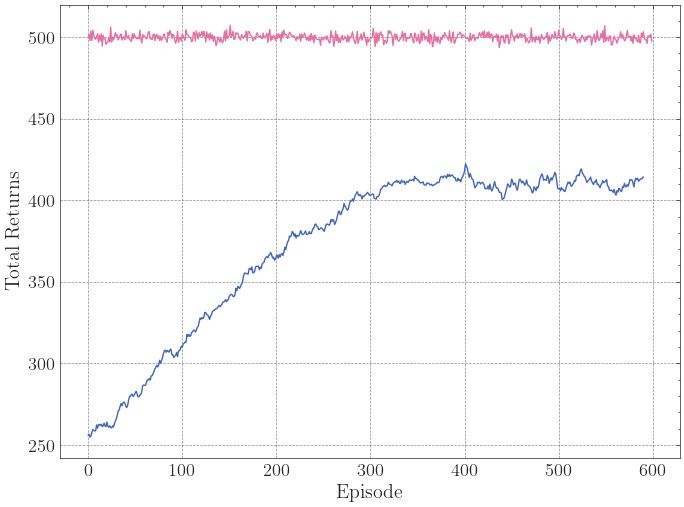

In [1062]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(591), rs)
plt.ylabel('Total Returns')
plt.xlabel('Episode')
plt.plot(np.arange(600), best_episode_reward)

In [1048]:
rs = np.array(pd.Series(episode_rewards).rolling(10).mean()[10 - 1:])

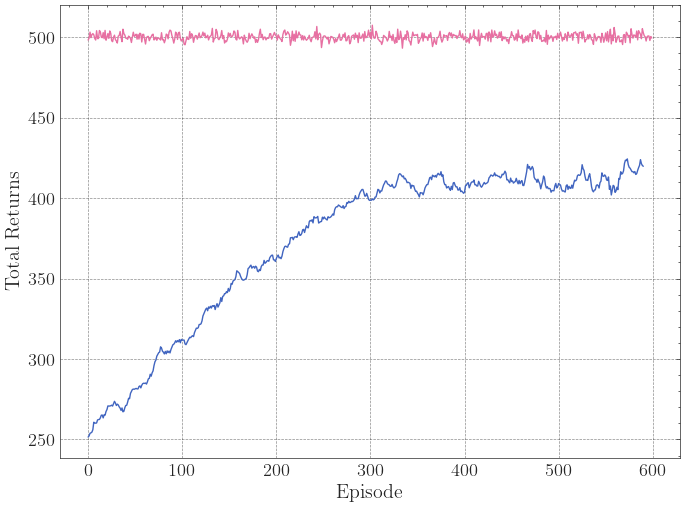

In [1049]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(591), rs)
plt.ylabel('Total Returns')
plt.xlabel('Episode')
plt.plot(np.arange(600), best_episode_reward)

# Visualising the weights 

In [966]:
av_weights = []
for i in range(600):
    avs = np.array(weights)[i][3:].mean(axis=0)
    av_weights.append(avs)
wn_over_time = list(zip(*av_weights))

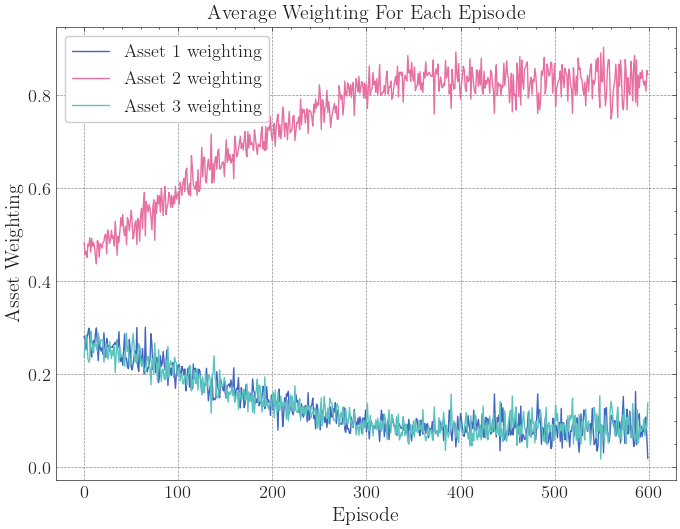

In [1068]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(wn_over_time[0], label='Asset 1 weighting')
plt.plot(wn_over_time[1], label='Asset 2 weighting')
plt.plot(wn_over_time[2], label='Asset 3 weighting')
plt.title('Average Weighting For Each Episode')
plt.xlabel('Episode')
plt.ylabel('Asset Weighting')
plt.legend()

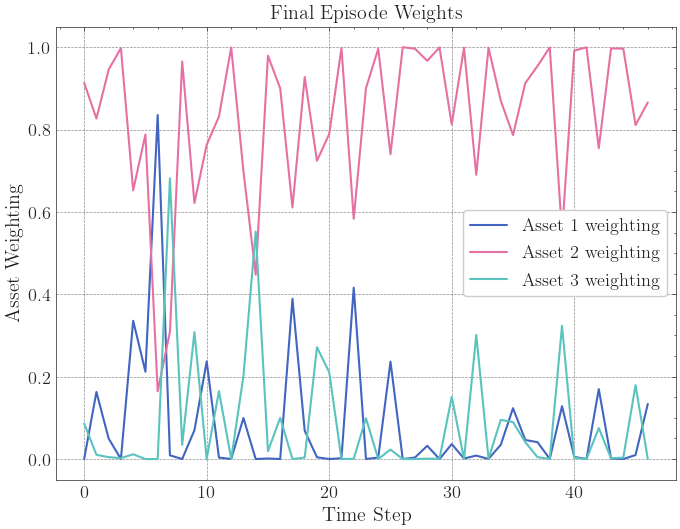

In [1067]:
final_weights = list(zip(*np.array(weights)[599][3:]))
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(final_weights[0], linewidth=1.5, label='Asset 1 weighting')
plt.plot(final_weights[1], linewidth=1.5, label='Asset 2 weighting')
plt.plot(final_weights[2], linewidth=1.5, label='Asset 3 weighting')
plt.title('Final Episode Weights')
plt.xlabel('Time Step')
plt.ylabel('Asset Weighting');
plt.legend()

# Visualising the Dirichlet Distribution

In [819]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [806]:
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))
def xy2bc(xy, tol=1.e-4):
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

In [807]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

In [1075]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

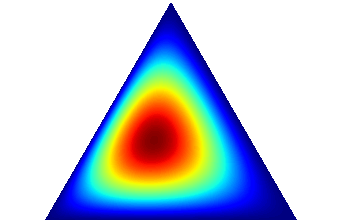

In [820]:
draw_pdf_contours(Dirichlet([2.45376263, 1.94288698, 2.39885103]))

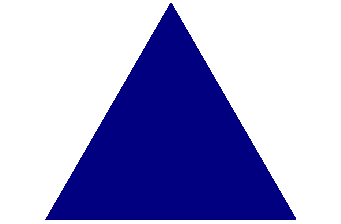

In [1076]:
draw_pdf_contours(Dirichlet(a))

# Looking at the Effect of the Concentration Parameter

In [942]:
low_s = np.array([dirichlet.rvs([1.1, 0.04])[0][0] for _ in range(10000)])
high_s = np.array([dirichlet.rvs([5, 0.04])[0][0] for _ in range(10000)])

In [943]:
low_perc = [np.sum([low_s < v])/100 for v in (0.5, 0.6, 0.7, 0.8, 0.9)]
high_perc = [np.sum([high_s < v])/100 for v in (0.5, 0.6, 0.7, 0.8, 0.9)]

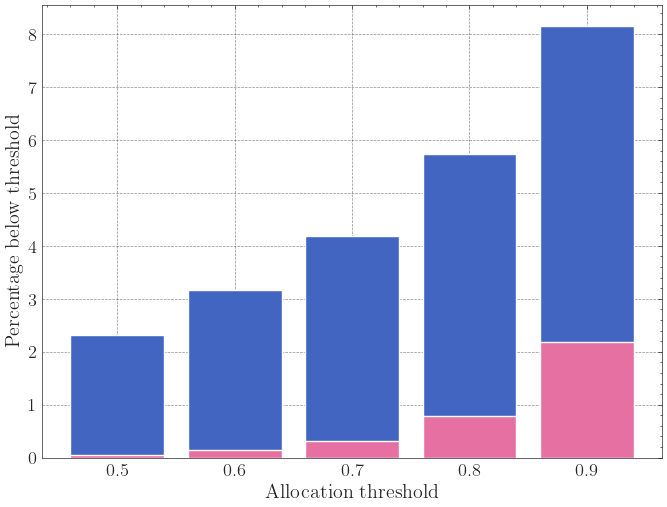

In [944]:
plt.figure(figsize=(8, 6), dpi=100)
plt.bar([1, 2, 3, 4, 5], low_perc)
plt.bar([1, 2, 3, 4, 5], high_perc)
plt.xlabel('Allocation threshold')
plt.ylabel('Percentage below threshold')
plt.xticks([1, 2, 3, 4, 5], [0.5, 0.6, 0.7, 0.8, 0.9]);

In [1077]:
low_s = np.array([dirichlet.rvs(a)[0][1] for _ in range(10000)])
low_perc = [np.sum([low_s < v])/100 for v in (0.4, 0.5, 0.6, 0.7, 0.8, 0.9)]

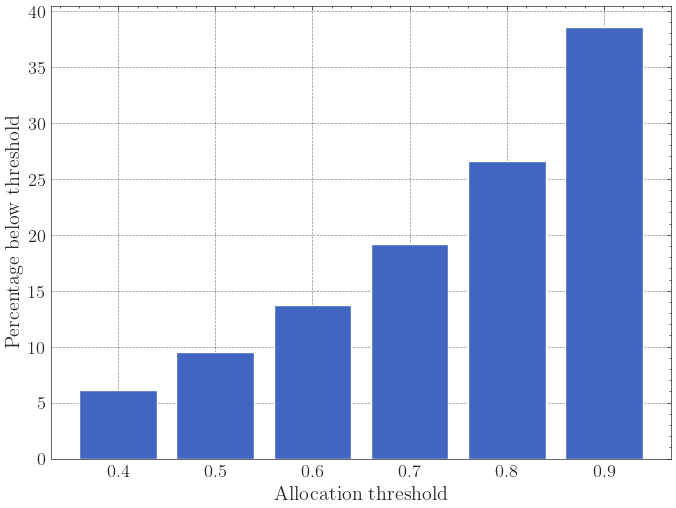

In [1078]:
plt.figure(figsize=(8, 6), dpi=100)
plt.bar([1, 2, 3, 4, 5, 6], low_perc)
plt.xlabel('Allocation threshold')
plt.ylabel('Percentage below threshold')
plt.xticks([1, 2, 3, 4, 5, 6], [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]);